In [407]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

In [408]:
# Load the data into a pandas DataFrame
df = pd.read_csv('~/Desktop/masterThesis/investmentfound/dataWithCycle.csv', parse_dates=['Date'])

# Extract the features and labels
X = df[
    ['SP500Returns', 
    'HousePriceIndex', 
    'RetailTrade', 
    'IRSpread', 
    'BuildingPermits', 
    'ConsumerSentiment', 
    'AvgWeeklyHoursProd',
    'FutureNewOrders',
    'DollarIndex',
    'ThreemonthsIR',
    'FiveyearsIR',
    'TenyearsIR',
    'ThirtyyearsIR',
    'IndProdInd',
    'DispPersIncome',
    'RealGDP',
    'ManTradeSales',
    'InvToSales',
    'AvgDurUnem',
    'YOYCoreCPI',
    'PrimeLendRate',
    'ConsumerDebtToIncome',
    'CommNndLoansAllBanks',
    'OutstandingLoans',
    'HousePriceIndex_pct_change',
    'RetailTrade_pct_change',
    'BuildingPermits_pct_change',
    'ConsumerSentiment_pct_change',
    'AvgWeeklyHoursProd_pct_change',
    'FutureNewOrders_pct_change',
    'ThreemonthsIR_pct_change',
    'FiveyearsIR_pct_change',
    'TenyearsIR_pct_change',
    'ThirtyyearsIR_pct_change',
    'IndProdInd_pct_change',
    'DispPersIncome_pct_change',
    'ManTradeSales_pct_change',
    'InvToSales_pct_change',
    'AvgDurUnem_pct_change',
    'PrimeLendRate_pct_change',
    'CommNndLoansAllBanks_pct_change',
    'PrimeLendRate_pct_change',
    'CommNndLoansAllBanks_pct_change',
    'OutstandingLoans_pct_change',
    'RealGDP_pct_change']
    ].values # features
y = df['Period'].values == "r" # labels

In [409]:
f"Shapes of X={X.shape} y={y.shape}, Recession periods={y.sum()}"

'Shapes of X=(535, 45) y=(535,), Recession periods=54'

In [427]:
# Create a TimeSeriesSplit object with 2 splits
n_splits = 2

tscv = TimeSeriesSplit(n_splits=n_splits, test_size=200)

# Split the data into a train and test set using TimeSeriesSplit
for i, (train_index, test_index) in enumerate(tscv.split(X)):
  print(f"Fold {i}:")
  print(f"  Train: index={train_index}")
  print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134]
  Test:  index=[135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236

<AxesSubplot: title={'center': 'TimeSeriesSplit'}, xlabel='Sample index', ylabel='CV iteration'>

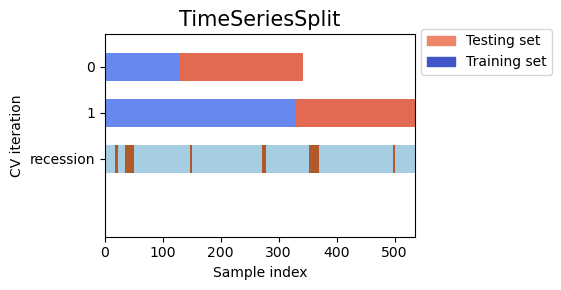

In [411]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, X, y, ax, n_splits, lw=20):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["recession"]

    ax.set(
        yticks=np.arange(n_splits + 1) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, len(X)],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)

    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)

    return ax

fig, ax = plt.subplots(figsize=(6, 3))
plot_cv_indices(tscv, X, y, ax, n_splits)

In [412]:
pipe = Pipeline([
    ("scale", StandardScaler()),
    ("model", GradientBoostingClassifier(random_state=42))
])

In [413]:
print(pipe.get_params())

{'memory': None, 'steps': [('scale', StandardScaler()), ('model', GradientBoostingClassifier(random_state=42))], 'verbose': False, 'scale': StandardScaler(), 'model': GradientBoostingClassifier(random_state=42), 'scale__copy': True, 'scale__with_mean': True, 'scale__with_std': True, 'model__ccp_alpha': 0.0, 'model__criterion': 'friedman_mse', 'model__init': None, 'model__learning_rate': 0.1, 'model__loss': 'log_loss', 'model__max_depth': 3, 'model__max_features': None, 'model__max_leaf_nodes': None, 'model__min_impurity_decrease': 0.0, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__min_weight_fraction_leaf': 0.0, 'model__n_estimators': 100, 'model__n_iter_no_change': None, 'model__random_state': 42, 'model__subsample': 1.0, 'model__tol': 0.0001, 'model__validation_fraction': 0.1, 'model__verbose': 0, 'model__warm_start': False}


In [414]:
#precision_score: given that I predict recession how accurate am I
#recall_score: did I get all the recession cases

mod = GridSearchCV(
    estimator=pipe, 
    param_grid={'model__n_estimators': [100, 150, 200]}, 
    scoring={'precision': make_scorer(precision_score), 'recall_score': make_scorer(recall_score)},
    refit='precision',
    return_train_score=True,
    cv=tscv)

mod.fit(X, y)

pd.DataFrame(mod.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,params,split0_test_precision,split1_test_precision,mean_test_precision,std_test_precision,...,std_train_precision,split0_test_recall_score,split1_test_recall_score,mean_test_recall_score,std_test_recall_score,rank_test_recall_score,split0_train_recall_score,split1_train_recall_score,mean_train_recall_score,std_train_recall_score
0,0.182929,0.048663,0.002212,0.001344,100,{'model__n_estimators': 100},0.8,0.279412,0.539706,0.260294,...,0.0,0.333333,0.95,0.641667,0.308333,1,1.0,1.0,1.0,0.0
1,0.229617,0.106467,0.000952,0.000005,150,{'model__n_estimators': 150},0.8,0.261538,0.530769,0.269231,...,0.0,0.333333,0.85,0.591667,0.258333,2,1.0,1.0,1.0,0.0
2,0.289504,0.152228,0.000925,0.000044,200,{'model__n_estimators': 200},0.8,0.253731,0.526866,0.273134,...,0.0,0.333333,0.85,0.591667,0.258333,2,1.0,1.0,1.0,0.0


In [415]:
#plt.scatter(X["SP500Returns"], X["IRSpread"], c=y)